In [1]:
import tensorflow_hub as hub
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import numpy as np
from tensorflow.keras import layers, models

In [2]:
with open('jiu_annotations.json', 'r') as file:
    annotations = json.load(file)

In [6]:
labels = {'standing': 0, 'takedown': 1, 'open_guard': 2, 'half_guard': 3, 'closed_guard': 4, '5050_guard': 5, 'side_control': 6, 'mount': 7, 'back': 8, 'turtle': 9}
body_parts = ["nose", "left eye", "right eye", "left ear", "right ear", "left shoulder", "right shoulder", "left elbow", "right elbow", "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle", "right ankle"]
num_labels = len(labels)
num_keypoints = 17

In [4]:
from random import shuffle

data = []

try:
    for annotation in annotations:
        label = annotation['position']
        if label[-1].isdigit():
            label = label[:-1]
        
        if annotation.get('pose1'):
            keypoints = annotation['pose1']
        else:
            keypoints = annotation['pose2']
            
        keypoints = np.array(keypoints).astype(np.float32).reshape(num_keypoints * 3)
        
        max_x = max(keypoints)
        normalized_keypoints = keypoints / max_x
        
        data.append((normalized_keypoints, labels[label]))
    
except Exception as e:
    print("Error:", e)
    
keypoints_list = []
labels_list = []

shuffle(data)

for keypoints, label in data:
    keypoints_list.append(keypoints)
    labels_list.append(label)
    
labels_list = np.array(labels_list)

file.close()


In [6]:
TRAIN_PERCENTAGE = 0.8

train_keypoints = keypoints_list[:int(len(keypoints_list) * TRAIN_PERCENTAGE)]
train_labels = labels_list[:int(len(labels_list) * TRAIN_PERCENTAGE)]

test_keypoints = keypoints_list[int(len(keypoints_list) * TRAIN_PERCENTAGE):]
test_labels = labels_list[int(len(labels_list) * TRAIN_PERCENTAGE):]

train_keypoints = np.array(train_keypoints)
train_labels = tf.keras.utils.to_categorical(train_labels)

test_keypoints = np.array(test_keypoints)
test_labels = tf.keras.utils.to_categorical(test_labels)

print("Train: ", len(train_keypoints))
print("Test: ", len(test_keypoints))

Train:  96223
Test:  24056


In [ ]:
from enum import Enum

class BodyPart(Enum):
    NOSE = 0
    LEFT_EYE = 1
    RIGHT_EYE = 2
    LEFT_EAR = 3
    RIGHT_EAR = 4
    LEFT_SHOULDER = 5
    RIGHT_SHOULDER = 6
    LEFT_ELBOW = 7
    RIGHT_ELBOW = 8
    LEFT_WRIST = 9
    RIGHT_WRIST = 10
    LEFT_HIP = 11
    RIGHT_HIP = 12
    LEFT_KNEE = 13
    RIGHT_KNEE = 14
    LEFT_ANKLE = 15
    RIGHT_ANKLE = 16
    
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""
  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

    It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
    """
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                    BodyPart.RIGHT_HIP)

    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                        BodyPart.RIGHT_SHOULDER)

    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                        BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size

def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
    scaling it to a constant pose size.
    """
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                    BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks

def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  
  reshaped_inputs = layers.Reshape((17, 3))(landmarks_and_scores)

  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])
  
  print(landmarks.shape)

  embedding = layers.Flatten()(landmarks)
  
  print(embedding.shape)

  return embedding

inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = layers.Dropout(0.2)(layer)
layer = layers.Flatten()(layer)
layer = layers.Dense(32, activation=tf.nn.relu6)(layer)
outputs = layers.Dense(num_labels, activation="softmax")(layer)

model = tf.keras.Model(inputs, outputs)
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpoint_path = "weights.best.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(train_keypoints, train_labels,
                    epochs=200,
                    batch_size=16,
                    validation_data=(test_keypoints, test_labels),
                    callbacks=[checkpoint, earlystopping])

In [ ]:
model.evaluate(test_keypoints, test_labels)

In [ ]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [108]:
import os

test_dict = {}

n = len(test_keypoints)

print(n)

for i in range(0, n):
    test = np.array([test_keypoints[i]])

    prediction = model.predict(test)
    
    correct_label = np.argmax(test_labels[i])
    predicted_label = np.argmax(prediction)
    
    label_name = list(labels.keys())[predicted_label]
    
    if predicted_label == correct_label:
        if label_name in test_dict:
            test_dict[label_name]["correct"] += 1
        else:
            test_dict[label_name] = {"correct": 1, "incorrect": 0}
    else:
        if label_name in test_dict:
            test_dict[label_name]["incorrect"] += 1
        else:
            test_dict[label_name] = {"correct": 0, "incorrect": 1}
            
    print(test_dict)


{'side_control': {'correct': 318, 'incorrect': 231}, 'standing': {'correct': 1088, 'incorrect': 185}, 'turtle': {'correct': 936, 'incorrect': 387}, 'back': {'correct': 708, 'incorrect': 355}, 'mount': {'correct': 473, 'incorrect': 527}, 'open_guard': {'correct': 738, 'incorrect': 745}, 'takedown': {'correct': 248, 'incorrect': 326}, 'half_guard': {'correct': 246, 'incorrect': 271}, 'closed_guard': {'correct': 475, 'incorrect': 177}, '5050_guard': {'correct': 221, 'incorrect': 77}}
1/1 [==============================] - 0s 19ms/step
{'side_control': {'correct': 318, 'incorrect': 231}, 'standing': {'correct': 1088, 'incorrect': 185}, 'turtle': {'correct': 936, 'incorrect': 387}, 'back': {'correct': 708, 'incorrect': 355}, 'mount': {'correct': 473, 'incorrect': 527}, 'open_guard': {'correct': 738, 'incorrect': 745}, 'takedown': {'correct': 248, 'incorrect': 326}, 'half_guard': {'correct': 246, 'incorrect': 271}, 'closed_guard': {'correct': 475, 'incorrect': 177}, '5050_guard': {'correct':

In [109]:
for key in test_dict:
    correct = test_dict[key]["correct"]
    incorrect = test_dict[key]["incorrect"]
    
    print(f"Accuracy for {key}: {correct / (correct + incorrect)}")

Accuracy for side_control: 0.559638942617666
Accuracy for standing: 0.8555716353111432
Accuracy for turtle: 0.7004287245444801
Accuracy for back: 0.6716314513335643
Accuracy for mount: 0.4840558939448226
Accuracy for open_guard: 0.5135796427697578
Accuracy for takedown: 0.41040843214756256
Accuracy for half_guard: 0.4796863863150392
Accuracy for closed_guard: 0.7133550488599348
Accuracy for 5050_guard: 0.7443037974683544


In [2]:
movenet_model = hub.load("../movenet")
movenet = movenet_model.signatures['serving_default']

model = models.load_model("../versions/v1/jiu_model.h5")


In [4]:
import matplotlib.pyplot as plt

IMAGE_SIZE = 300

image_path = '../test_images/standing.jpg'
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
X = tf.expand_dims(image, axis=0)
X = tf.cast(tf.image.resize_with_pad(X, 256, 256), dtype=tf.int32)

def make_pred(img, keypoints_dict, label):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img[0])
    plt.title('Pose')
    plt.axis('off')
    
    for i in range(17):
        plt.scatter(keypoints_dict[label[i]][1],keypoints_dict[label[i]][0],color='green')

    connections = [
        ('nose', 'left eye'), ('left eye', 'left ear'), ('nose', 'right eye'), ('right eye', 'right ear'),
        ('nose', 'left shoulder'), ('left shoulder', 'left elbow'), ('left elbow', 'left wrist'),
        ('nose', 'right shoulder'), ('right shoulder', 'right elbow'), ('right elbow', 'right wrist'),
        ('left shoulder', 'left hip'), ('right shoulder', 'right hip'), ('left hip', 'right hip'),
        ('left hip', 'left knee'), ('right hip', 'right knee'), ('left knee', 'left ankle'), ('right knee', 'right ankle')
    ]

    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key][:2]  # Take first two values
            end_point = keypoints_dict[end_key][:2]      # Take first two values
            plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], linewidth=2)
    
    plt.subplot(1, 3, 3)
    plt.imshow((img[0]/255)/255)
    plt.title('Only Pose Image')
    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key][:2]  # Take first two values
            end_point = keypoints_dict[end_key][:2]      # Take first two values
            plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], linewidth=2)
            
img = tf.image.resize_with_pad(image, 256, 256)
img = tf.cast(img, dtype=tf.int32)
img = tf.expand_dims(img, axis=0)
img = img.numpy()


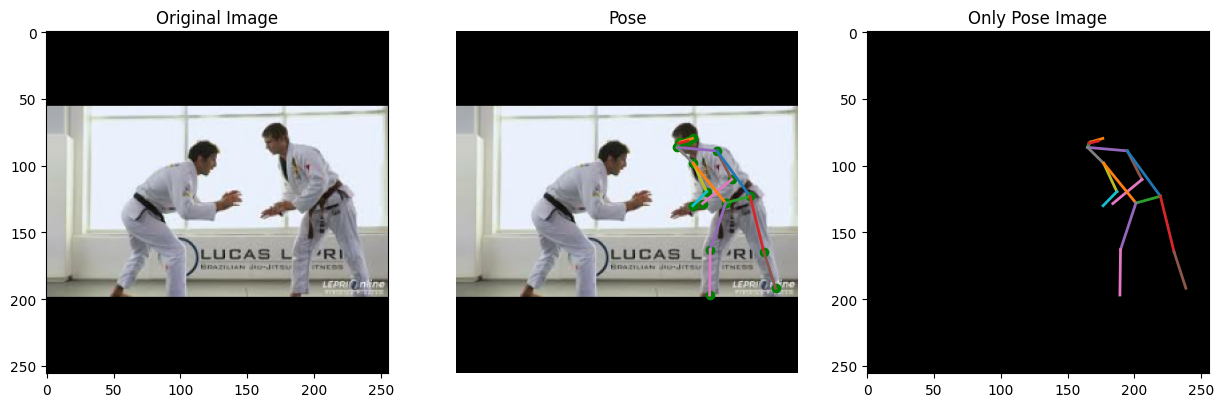

In [7]:
outputs = movenet(X)
keypoints = outputs['output_0'].numpy()

max_key,key_val = keypoints[0,:,55].argmax(),keypoints[0,:,55].max()
max_key,key_val
max_points = keypoints[0,max_key,:]
max_points = max_points*256
max_points = max_points.astype(float)

keypoints_dict = {}
for i in range(0,len(max_points)-5,3):
    keypoints_dict[body_parts[i//3]] = [max_points[i],max_points[i+1],max_points[i+2]]
    
make_pred(img, keypoints_dict, body_parts)

new_keypoints = []

for key in keypoints[0]:
    new_keypoints.append(np.array(key[:51]))
    
keypoints = np.array(new_keypoints)[0].astype(np.float32).reshape(1, num_keypoints * 3)

In [8]:
pred = model.predict(keypoints)

print(pred)

max_index = np.argmax(pred[0])

print(labels.keys())
print(max_index)

1/1 [==============================] - 0s 76ms/step
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
dict_keys(['standing', 'takedown', 'open_guard', 'half_guard', 'closed_guard', '5050_guard', 'side_control', 'mount', 'back', 'turtle'])
6
